In [1]:
import os
from pandas import read_csv
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from scipy.sparse import hstack
import warnings
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, balanced_accuracy_score
warnings.filterwarnings("ignore")

## Data Preparation

In [3]:
final_path = '/Users/subashkhanal/Desktop/BMI633/ADNI_Genetics/gene_expression/data/'
df = pd.read_csv(os.path.join(final_path,'Unfiltered_gene_expr_dx.csv'),low_memory=False)
from collections import Counter

print(Counter(df['DX_bl']))

df_CN = df[df['DX_bl']=='CN']
df_AD = df[df['DX_bl']=='AD']
df_EMCI = df[df['DX_bl']=='EMCI']
df_LMCI = df[df['DX_bl']=='LMCI']
df_AD2 =  df[(df['DX_bl']=='LMCI') | (df['DX_bl']=='AD')] #Combine AD with LMCI
df_AD2['DX_bl'] = 'AD2'
Counter(df_AD2.DX_bl)

Counter({'CN': 260, 'LMCI': 225, 'EMCI': 215, 'AD': 43, nan: 1})


Counter({'AD2': 268})

# t-test as Feature selection 

In [55]:
from scipy import stats
df_CN_exp = df_CN.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_AD_exp = df_AD.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_EMCI_exp = df_EMCI.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_LMCI_exp = df_LMCI.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_AD2_exp = df_AD2.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')

p = []
data = df_CN_exp
from scipy import stats
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for CN group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution


p = []
data = df_EMCI_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for EMCI group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

p = []
data = df_LMCI_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for LMCI group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

p = []
data = df_AD_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for AD group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

p = []
data = df_AD2_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for AD2 group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

from scipy.stats import ttest_ind
import statsmodels.stats.multitest as multi

fdr_alpha =0.10 ##DEFAULT IS 0.05
alpha = fdr_alpha
gene_probes = df_AD_exp.columns
groups = ['CN_AD','CN_AD_c','CN_AD2','CN_AD2_c','CN_EMCI','CN_EMCI_c','CN_LMCI','CN_LMCI_c', 'EMCI_LMCI','EMCI_LMCI_c','EMCI_AD','EMCI_AD_c','LMCI_AD','LMCI_AD_c']
df_p = pd.DataFrame(columns=groups, index = gene_probes) #dataframe for collecting p values for test

for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_AD'],alpha = fdr_alpha) #FDR correction 
df_p['CN_AD_c'] = corr_p 
       

for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_AD2_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_AD2'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_AD'],alpha = fdr_alpha) #FDR correction 
df_p['CN_AD2_c'] = corr_p 


for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_AD'],alpha = fdr_alpha) #FDR correction 
df_p['CN_AD_c'] = corr_p 
       
for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_EMCI_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_EMCI'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_EMCI'],alpha = fdr_alpha) #FDR correction
df_p['CN_EMCI_c'] = corr_p 

for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_LMCI_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_LMCI'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_LMCI'],alpha = fdr_alpha) #FDR correction
df_p['CN_LMCI_c'] = corr_p 

for gene in gene_probes:
    data1 = df_EMCI_exp[gene]
    data2 = df_LMCI_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'EMCI_LMCI'] = p
hyp, corr_p = multi.fdrcorrection(df_p['EMCI_LMCI'],alpha = fdr_alpha) #FDR correction 
df_p['EMCI_LMCI_c'] = corr_p 
       
for gene in gene_probes:
    data1 = df_EMCI_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'EMCI_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['EMCI_AD'],alpha = fdr_alpha) #FDR correction
df_p['EMCI_AD_c'] = corr_p 

for gene in gene_probes:
    data1 = df_LMCI_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'LMCI_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['LMCI_AD'],alpha = fdr_alpha) #FDR correction
df_p['LMCI_AD_c'] = corr_p 

df_p1 = df_p.reset_index()
df_p2 = df_p1.rename(columns={'index':'Gene'})
df_p2.to_csv(os.path.join(final_path,'t_test_0.10_geneExpr_Unfiltered_bl.csv'))
print("Ttest calculated for all the unfiltered probes among all baseline diagnostic groups in Gene Expression data")

Average P value for normality test for all features for CN group is: 0.15471668443855968
Average P value for normality test for all features for EMCI group is: 0.18720201363835318
Average P value for normality test for all features for LMCI group is: 0.16997089791068903
Average P value for normality test for all features for AD group is: 0.39529632415664845
Average P value for normality test for all features for AD2 group is: 0.1519048757424573
Ttest calculated for all the unfiltered probes among all baseline diagnostic groups in Gene Expression data


In [56]:
overall_groups = ['CN_AD','CN_EMCI','CN_LMCI','EMCI_LMCI','EMCI_AD','LMCI_AD']

## Classifier

In [4]:
N = 50
data_path = final_path
groups = 'CN_AD'
classes = groups.split('_')
#Gene ranking based on ttest
ttest = read_csv(os.path.join(data_path,'t_test_0.10_geneExpr_Unfiltered_bl.csv')).sort_values(groups).reset_index()
important_probes = ttest.sort_values(groups+'_c')['Gene'][0:N] #suffix _c to use the FDR corrected p values 
#CHANGE THE LINE ABOVE ACCORDINGLY FOR DIFFERENT CLASSES

#Gene Expression Data
data_path = '/Users/subashkhanal/Desktop/BMI633/ADNI_Genetics/gene_expression/data/'
df = pd.read_csv(os.path.join(data_path,'Unfiltered_gene_expr_dx.csv'),low_memory=False)
Gene_expr = df[['Unnamed: 0','AGE','PTGENDER','PTEDUCAT','DX_bl']+list(important_probes)]
df = Gene_expr
df_CN = df[df['DX_bl']=='CN']
df_AD = df[df['DX_bl']=='AD']
df_EMCI = df[df['DX_bl']=='EMCI']
df_LMCI = df[df['DX_bl']=='LMCI']
df_AD2 =  df[(df['DX_bl']=='LMCI') | (df['DX_bl']=='AD')] #Combine AD with LMCI
df_AD2['DX_bl'] = 'AD2'

curr_df = pd.concat([df_LMCI, df_AD], ignore_index=True) #CHANGE THIS LINE ACCORDINGLY FOR DIFFERENT CLASSES
curr_df['PTGENDER'] = curr_df['PTGENDER'].astype('category').cat.codes 

In [5]:
Counter(df.DX_bl)

Counter({'CN': 260, 'AD': 43, 'EMCI': 215, 'LMCI': 225, nan: 1})

In [6]:
Counter(curr_df.DX_bl)

Counter({'LMCI': 225, 'AD': 43})

In [7]:
curr_df.columns[curr_df.isna().any()].tolist()

[]

In [21]:
from sklearn.preprocessing import LabelBinarizer

def prepare_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    return y

#Very inefficient approach! but is easier to visualize in my head
def data_prep(df): #This takes the dataframe and returns the one hot encoded expansion of input features
    target = prepare_targets(list(df.DX_bl))
    df1 = df.drop(columns=['Unnamed: 0','DX_bl']).reset_index(drop=True) #Patient ID and DIAG not needed  
    return df1, target
df, y = data_prep(curr_df)
print(df.shape, y.shape)

(268, 53) (268,)


In [9]:
from sklearn.feature_selection import RFECV
estimator = GradientBoostingClassifier(random_state=1,n_estimators=2*df.shape[1])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
selector = RFECV(estimator,  n_jobs=-1,step=1, cv=cv)
selector = selector.fit(df, y)

In [10]:
df = df.loc[:, selector.support_]

In [19]:
final_N = df.shape[1]

## Hyperparameters Grid Search

Adapted from https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

Best Score: 0.5868518518518518
Best Hyperparameters: {'n_estimators': 150}
Automatically created module for IPython interactive environment


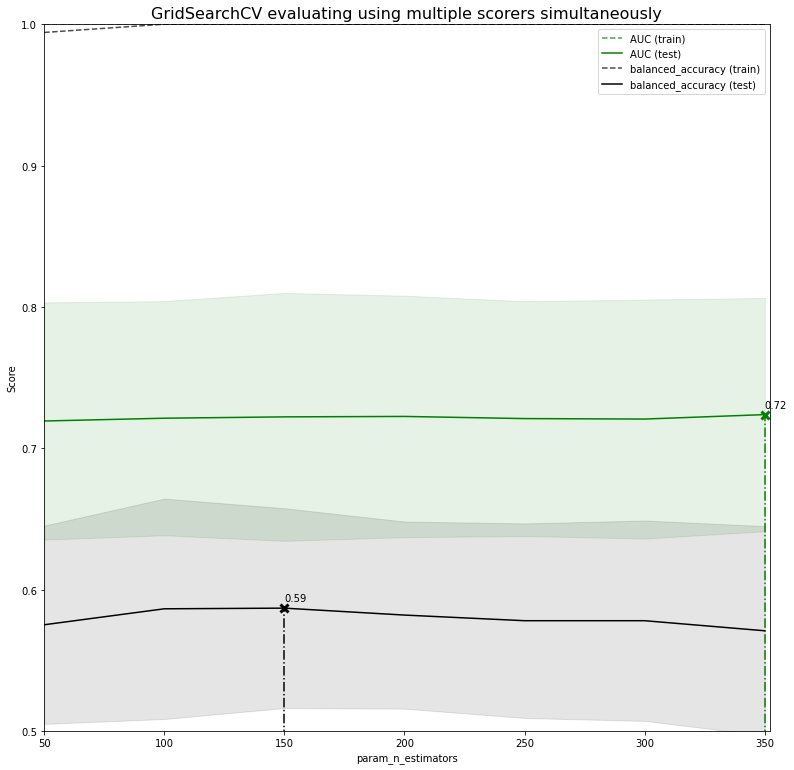

In [16]:
#Adapted from #https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD
groups = 'CN_AD'
model = Pipeline([
        ('sampling', SMOTE(sampling_strategy=0.7, k_neighbors=7,random_state=1)),
        ('classifier', GradientBoostingClassifier(random_state=1))
    ])
space = dict()
X, y = df, y
# define model
model = GradientBoostingClassifier(random_state=1)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_estimators'] = range(50,5*X.shape[1],50)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy':'balanced_accuracy'}
# define search
search = GridSearchCV(model, space,n_jobs=-1, cv=cv,scoring=scoring, refit='balanced_accuracy', return_train_score=True)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
results = search.cv_results_

print(__doc__)
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("param_n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(space['n_estimators']), max(space['n_estimators'])+2)
ax.set_ylim(0.50, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('./results/Grid_search_Using_GeneExpr_for:'+groups+'.png')

## Final Run and Save Results

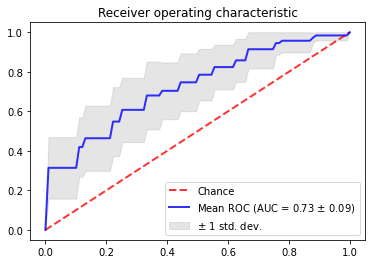

for total of  40 Features
Mean Balanced Accuracy: 0.6380555555555556
Mean AUC: 0.725164609053498
END OF THE EXPERIMENT


<Figure size 432x288 with 0 Axes>

In [20]:
tprs = []
aucs = []
acc = []
imp = []
mean_fpr = np.linspace(0, 1, 100)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
fig, ax = plt.subplots()
X, y = df, y
for train, test in cv.split(X, y):
    X_train = X.iloc[train]
    y_train = y[train]
    
    X_test = X.iloc[test]
    y_test = y[test]
    n_estimators = result.best_params_['n_estimators']
    model = GradientBoostingClassifier(random_state=1,n_estimators=n_estimators)
    oversample = SMOTE(sampling_strategy=0.7, k_neighbors=7,random_state=1)
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    y_pred = model.predict(X_test)
    acc.append(balanced_accuracy_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],drop_intermediate='False')
    roc_auc = roc_auc_score(y_test, probas_[:, 1])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    imp.append(model.feature_importances_)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()
plt.savefig('./results/ROC_for:'+groups+'.png')
print('for total of ',final_N,"Features")
print('Mean Balanced Accuracy:',sum(acc)/len(acc))
print('Mean AUC:',sum(aucs)/len(aucs))

imp = np.array(imp)
imp = imp.mean(axis=0)

imp_df = pd.DataFrame(columns=['features','importance'])
imp_df['features'] = list(X.columns)
imp_df['importance'] = imp

imp_df_sorted = imp_df.sort_values(by=['importance'],ascending=False)
imp_df_sorted.to_csv('./results/'+groups+'_Classification_ranked_'+str(final_N)+'Genomic_features.csv')

print("END OF THE EXPERIMENT")